In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.5"
import jax
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['figure.dpi'] = 200


from hyperion.models.photon_arrival_time.pdf import make_exp_exp_exp, make_obj_func, sample_exp_exp_exp, fb5_mle
from hyperion.models.photon_arrival_time.net import PhotonArivalTimePars
from hyperion.utils import cherenkov_ang_dist, calc_tres, cherenkov_ang_dist_int
import pickle

from tqdm.notebook import trange, tqdm
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline

from glob import glob
import json

from train_net import make_funnel

import haiku as hk

import jax.numpy as jnp
import optax
import functools

[]

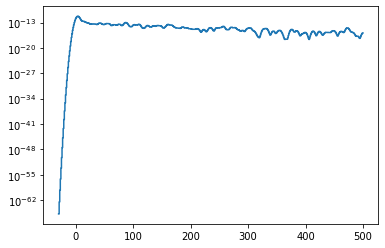

In [2]:
data = pickle.load(open("data/photon_hists_2_2.pickle", "rb"))
binning = np.linspace(-30, 500, 530)
plt.step(binning, np.append(data[1][0], data[1][0][-1]), where="post")
plt.semilogy()


In [2]:
class SimpleDataset(object):
    """Simple Dataset subclass that returns a tuple (input, output)."""

    def __init__(self, inputs, outputs, sanitize=True):
        super(SimpleDataset, self).__init__()
        self._inputs = inputs
        self._outputs = outputs
        self._sanitize = sanitize

        if len(self._inputs) != len(self._outputs):
            raise ValueError("Inputs and outputs must have same length.")

        self._len = len(self._inputs)

    def __getitem__(self, idx):
        """Return tuple of input, output."""
        out = self._outputs[idx]
        
        if isinstance(idx, int):
            idx = [idx]
        
        if self._sanitize:
            mask = np.isfinite(out)
            out[~mask] = 0
            return np.atleast_2d(self._inputs[idx]), np.atleast_2d(out), np.atleast_2d(mask)
        
        return np.atleast_2d(self._inputs[idx]), np.atleast_2d(out)

    def __len__(self):
        return self._len

    
class SubSet(object):
    def __init__(self, dataset, subset_ix):
        super(SubSet, self).__init__()
        if max(subset_ix) > len(dataset):
            raise RuntimeError("Invalid index")
        
        self._subset_ix = subset_ix
        self._len = len(subset_ix)
        self._dataset = dataset
        
    def __len__(self):
        return self._len
        
    def __getitem__(self, idx):
        true_ix = self._subset_ix[idx]
        return self._dataset[true_ix]
    
    
def create_random_split(dataset, split_len, rng):
    ixs = np.arange(len(dataset))
    rng.shuffle(ixs)
    first_split = SubSet(dataset, ixs[:split_len])
    second_split = SubSet(dataset, ixs[split_len:])
    
    return first_split, second_split

def randomize_ds(dataset, rng):
    ixs = np.arange(len(dataset))
    rng.shuffle(ixs)
    return SubSet(dataset, ixs)
    

class DataLoader(object):
    def __init__(self, dataset, batch_size, rng, shuffle=False):
        self._dataset = dataset
        self._batch_size = batch_size
        self._rng = rng
        self._shuffle = shuffle
        self._n_batches =  int(np.ceil(len(self._dataset) / self._batch_size))
        
    def __iter__(self):
        if self._shuffle:
            ds = randomize_ds(self._dataset, self._rng)
        else:
            ds = self._dataset              
        
        for batch in range(self._n_batches):
            upper = min(len(ds), (batch+1)*self._batch_size)
            ixs = np.arange(batch*self._batch_size, upper)
            yield ds[ixs]
            
            
    @property
    def n_batches(self):
        return self._n_batches
    
    
    
    

In [3]:

class HistMLP(hk.Module):
    
    def __init__(self, output_size,  layers, dropout, final_activations, name=None):
        super().__init__(name=name)
        self.output_size = output_size
        self.layers = layers
        self.dropout = dropout
        self.final_activations = final_activations
        
    
    def __call__(self, x, is_training):
        for n_per_layer in self.layers:
            x = hk.Linear(n_per_layer)(x)
            #x = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9)(x, is_training=is_training)
            x = jax.nn.relu(x)
            if is_training:
                key = hk.next_rng_key()
                x = hk.dropout(key, self.dropout, x)
            
        x = hk.Linear(self.output_size)(x)

        if self.final_activations is not None:
            x = self.final_activations(x)

        return x




In [4]:
def make_forward_fn(conf):
    layers = [conf["n_neurons"], conf["n_neurons"], conf["n_neurons"]]
        
    def forward_fn(batch, is_training):
        inp = jnp.asarray(batch[0], dtype=jnp.float32)
        return HistMLP(conf["n_out"], layers, conf["dropout"], None)(inp, is_training)
    return forward_fn


def train_net(conf, train_data, test_data, writer, rng):

    train_loader = DataLoader(
        train_data,
        batch_size=conf["batch_size"],
        shuffle=True,
        # worker_init_fn=seed_worker,
        rng=rng,
    )
    test_loader = DataLoader(
        test_data,
        batch_size=conf["batch_size"],
        shuffle=False,
        # worker_init_fn=seed_worker,
        rng=rng,
    )
    
    
    forward_fn = make_forward_fn(conf)

    net = hk.transform_with_state(forward_fn)
    key = hk.PRNGSequence(42)
    
    inp = jnp.array([1., 1. ])
    params, state = net.init(next(key), next(iter(train_loader)), is_training=True)
    avg_params = params
    
    schedule = optax.cosine_decay_schedule(conf["lr"], conf["epochs"]*train_loader.n_batches, alpha=0.0)
    
    opt = optax.adam(learning_rate=schedule)
    opt_state = opt.init(params)

    def loss(params, state, rng_key, batch, is_training):
        pred, _ = net.apply(params, state, rng_key, batch, is_training)
        target = batch[1]
        mask = batch[2]
        se = 0.5 * (pred - target)**2
        
        nonzero = jnp.sum(mask, axis=0)        
        mse = (jnp.sum(jnp.where(mask, se, jnp.zeros_like(se)), axis=0) / nonzero).sum()

        #regul = (jnp.diff(pred, axis=1, n=3)**2).sum() + (jnp.diff(pred, axis=1, n=4)**2).sum()

        first_diff = jnp.diff(pred, axis=1)
        first_diff_n = (first_diff - jnp.mean(first_diff, axis=1)[:, np.newaxis]) / jnp.std(first_diff, axis=1)[:, np.newaxis]
        roughness = ((jnp.diff(first_diff_n, axis=1) ** 2) / 4).sum()

        roughness_weight = 2

        return 1/(roughness_weight + 1) * (mse + roughness_weight * roughness)

    @functools.partial(jax.jit, static_argnums=[5])
    def get_updates(
          params,
          state,
          rng_key,
          opt_state,
          batch,
          is_training
      ):
        """Learning rule (stochastic gradient descent)."""
        l, grads = jax.value_and_grad(loss)(params, state, rng_key, batch, is_training=is_training)
        updates, opt_state = opt.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return l, new_params, opt_state
    
    
    @jax.jit
    def ema_update(params, avg_params):
        return optax.incremental_update(params, avg_params, step_size=0.001)


    for epoch in range(conf["epochs"]):
        # Train/eval loop.
        train_loss = 0
        for train in train_loader:
            rng_key = next(key)
            # Do SGD on a batch of training examples.
            l, params, opt_state = get_updates(params, state, rng_key, opt_state, train, is_training=True)
            avg_params = ema_update(params, avg_params)
            
            train_loss += l * len(train[0])
        train_loss /= len(train_data)
        
        test_loss = 0
        for test in test_loader:
            test_loss += loss(avg_params, state, None, test, is_training=False) * len(test[0])
        test_loss /= len(test_data)
     
        #print(opt_state[1].count)
        if writer is not None:
            train_loss, test_loss, lr = jax.device_get(
              (train_loss, test_loss, schedule(opt_state[1].count)))
            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Loss/test", test_loss, epoch)
            writer.add_scalar("LR", lr, epoch)

  
            
    @jax.jit
    def net_eval_fn(x):
         return net.apply(avg_params, state, None, x, is_training=False)[0]
        
    return net_eval_fn, avg_params, state

    """
    if writer is not None:
        net.eval()

        inp, out = test_data[:]
        pred = net(inp)

        loss = criterion(pred, out)
        loss = loss.sum() / len(test_data)

        hparam_dict = dict(conf)
        del hparam_dict["final_activations"]
        writer.add_hparams(hparam_dict, {"hparam/test_loss": loss.item()})
        writer.flush()
        writer.close()
        
    return net
    """


In [5]:
!rm -rf /tmp/tensorboard/runs/*

In [6]:

#for tts in [2, 3, 4]:
#for tts in [0]:
tts = 2
hists = pickle.load(open(f"data/combined_photon_hists_{tts}.pickle", "rb"))
inputs = np.asarray(hists[::2])
outputs = np.asarray(hists[1::2])
inputs = inputs.reshape((inputs.shape[0] * inputs.shape[1], 2))
outputs = outputs.reshape((outputs.shape[0] * outputs.shape[1], 529))

"""
bin_width = 1 # ns
noise_rate = 1E3 * 16 / 1E9
noise_hits =  noise_rate * bin_width

outputs += noise_hits
"""

outputs = np.log(outputs)

first_finite = np.nonzero(np.sum(~np.isfinite(outputs), axis=0) / outputs.shape[0] < 0.5)[0][0]
#print(first_finite)
outputs[:, :first_finite] = -300

binning = jnp.arange(-30, 500, 1)


inputs[:, 1] = jnp.log10(inputs[:, 1])
data = SimpleDataset(inputs, outputs)
split = int(0.5*len(data))
rng = np.random.RandomState(2)
train_data, test_data = create_random_split(data, split, rng)


conf = {
        "batch_size" : 500,
        "n_in": 2,
        "n_out": outputs.shape[1],
        "dropout": 0.2,
        #"final_activations": [nn.Identity()]*outputs.shape[1],
        "lr": 0.005,
        "epochs": 600,
        "n_neurons": 1000
    }
writer = SummaryWriter(
    f"/tmp/tensorboard/runs/hist_test_{conf['batch_size']}_{conf['lr']}_{conf['epochs']}_{conf['dropout']}_{conf['n_neurons']}"
)


net, params, state = train_net(conf, train_data, test_data, writer, rng)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


In [7]:
pickle.dump([params, state, conf], open("data/arrival_hist_net_2tts_jax.pickle", "wb"))

params, state, conf = pickle.load( open("data/arrival_hist_net_2tts_jax.pickle", "rb"))
forward_fn = make_forward_fn(conf)
net = hk.transform_with_state(forward_fn)

@jax.jit
def net_eval_fn(x):
    return net.apply(params, state, None, x, is_training=False)[0]



In [10]:
for n_neurons in [1000]:
    for epochs in [700, 900, 1000]:
        for lr in [0.007, 0.01, 0.02]:
            for dropout in [0, 0.1, 0.2]:
                conf = {
                    "batch_size" : 500,
                    "n_in": 2,
                    "n_out": outputs.shape[1],
                    "dropout": dropout,
                    "lr": lr,
                    "epochs": epochs,
                    "n_neurons": n_neurons
                }
            writer = SummaryWriter(
                f"/tmp/tensorboard/runs/hist_test_{conf['batch_size']}_{conf['lr']}_{conf['epochs']}_{conf['dropout']}_{conf['n_neurons']}"
            )

        train_net(conf, train_data, test_data, writer, rng)
            



KeyboardInterrupt: 

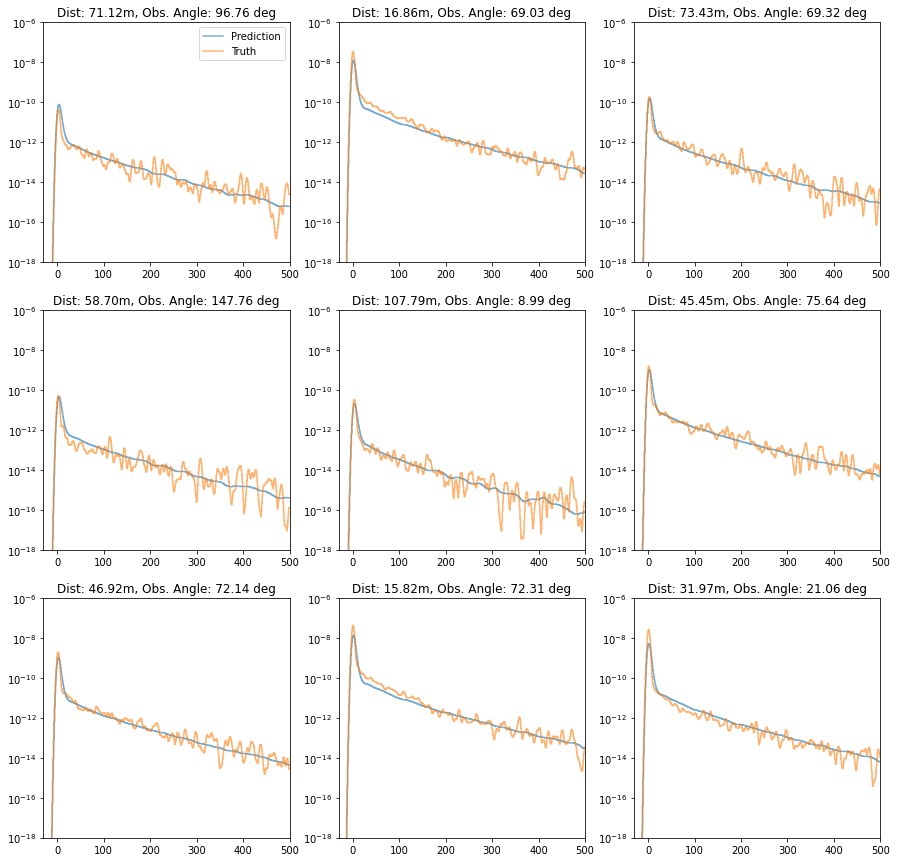

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

rng = np.random.RandomState(2)

ixs = rng.choice(len(test_data), size=9)

for ax, ix in zip(axs.ravel(), ixs):

    net_in = test_data[ix]
    nn_out = net_eval_fn(net_in)[0]
    truth = net_in[1][0]
    
    ax.step(binning, np.exp(np.append(nn_out, nn_out[-1])), alpha=0.6, label="Prediction", where="post")
    ax.step(binning, np.exp(np.append(truth, truth[-1])), alpha=0.6, label="Truth", where="post")

    ax.set_yscale("log")
    ax.set_title(f"Dist: {10**net_in[0][0][1]:.2f}m, Obs. Angle: {np.degrees(net_in[0][0][0]):.2f} deg")
    ax.set_xlim(-30, 500)
    axs[0][0].legend()
    ax.set_ylim(1E-18, 1E-6)

AttributeError: 'CompiledFunction' object has no attribute 'eval'

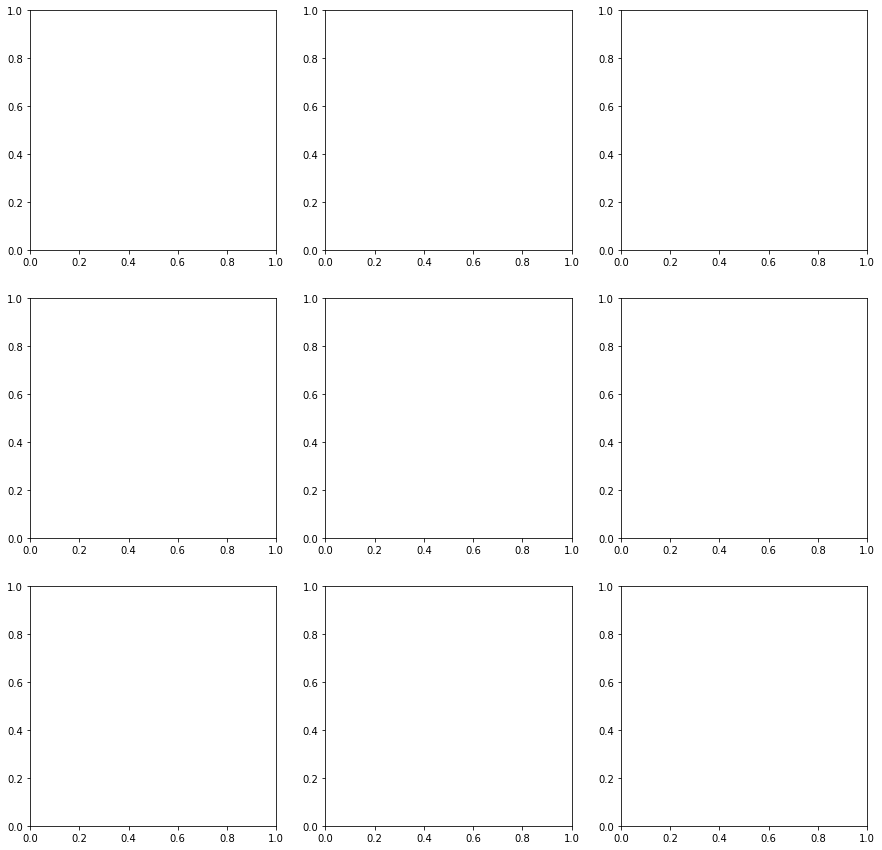

In [31]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

rng = np.random.RandomState(0)

ixs = rng.choice(len(test_data), size=9)

net.eval()
binning = np.linspace(0, 500, 500)

for ax, ix in zip(axs.ravel(), ixs):

    net_in = test_data[ix][0][np.newaxis, :]
    nn_out = net(net_in)[0].detach().cpu().numpy()
    truth = test_data[ix][1].detach().cpu().numpy()
    ax.step(binning, 10**np.append(nn_out, nn_out[-1]), alpha=0.6, label="Prediction", where="post")
    ax.step(binning, 10**np.append(truth, truth[-1]), alpha=0.6, label="Truth",  where="post")

    ax.set_yscale("log")
    ax.set_ylim(1E-2, 1E7)
    ax.set_title(f"Dist: {10**net_in[0][1].cpu():.2f}m, Obs. Angle: {np.degrees(net_in[0][0].cpu()):.2f} deg")
    ax.set_xlim(0, 50)
axs[0][0].legend()
    

In [9]:
net = torch.load("data/arrival_hist_net.dat")

[]

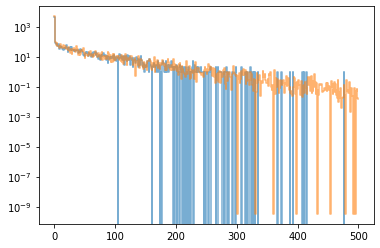

In [20]:
from hyperion.models.binned.binned import sample_poisson
gen = torch.Generator(device=torch.device("cuda"))
net_in = test_data[0][0][np.newaxis, :]
binning = np.linspace(0, 500, 500)
fig, ax = plt.subplots()
pred = sample_poisson(net, net_in, gen).detach().cpu().numpy()[0]
truth = test_data[0][1].detach().cpu().numpy()
ax.step(binning, np.append(pred, pred[-1]), alpha=0.6, label="Prediction", where="post")
ax.step(binning, 10**np.append(truth, truth[-1]), alpha=0.6, label="Truth",  where="post")
plt.semilogy()

In [ ]:
from gnn_testbed.event_generation.photon_propagation import source_to_model_input,